In [1]:
# +
from dataset.semi_cv2 import SemiDataset
from model.semseg.deeplabv2 import DeepLabV2
from model.semseg.deeplabv3plus import DeepLabV3Plus
from model.semseg.pspnet import PSPNet
from utils.utils import count_params, meanIOU, color_map, DiceCoefficient
from dataset.transform import image_only_transform, shared_transform
from utils.DICELOSS import DiceLoss
from utils.loss_file import save_loss
# -

import argparse
from copy import deepcopy
import numpy as np
import os
import json
from PIL import Image
import torch
from torch.nn import CrossEntropyLoss, DataParallel, functional as F
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss, DataParallel, functional as F
import albumentations as albu

In [2]:
semi_setting = 'kidney/1-3'
save_path = f'outdir/models/{semi_setting}'
pseudo_mask_path = f'outdir/pseudo_masks/{semi_setting}'
labeled_id_path = f'dataset/splits/{semi_setting}/train.txt'
unlabeled_id_path = f'dataset/splits/{semi_setting}/unlabeled.txt'
reliable_id_path = f'outdir/reliable_ids/{semi_setting}'

# data_root = '/home/S312112021/dataset/0_data_dataset_voc_950'
data_root = 'data/0_data_dataset_voc_950'
batch_size = 4
crop_size = 224
plus = True
dataset ='kidney'


if not os.path.exists(save_path):
    os.makedirs(save_path)
if not os.path.exists(pseudo_mask_path):
    os.makedirs(pseudo_mask_path)
if plus and reliable_id_path is None:
    exit('Please specify reliable-id-path in ST++.')

image.shape:  (224, 224, 3)


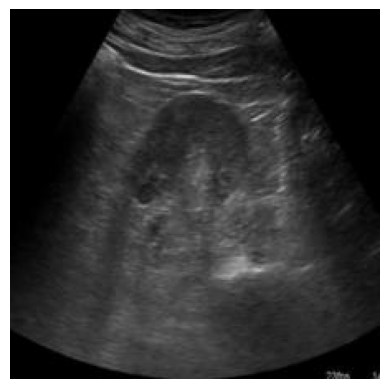

In [3]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def plt_img(image):
    image_pil = Image.fromarray(image) # cv2 to pil
    # 顯示圖片
    plt.imshow(image_pil, cmap='gray')
    plt.axis('off')
    plt.show()

image = cv2.imread('data/0_data_dataset_voc_950/JPEGImages/1000221_8_DATE20140630_STD02_SER01_IMG013.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) 
print('image.shape: ', image.shape)

plt_img(image)

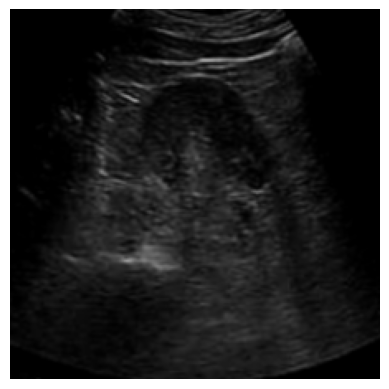

In [4]:
# Augment an image
sample = image_only_transform(image=image)
image = sample["image"]
transformed = shared_transform(image=image)

transformed_image = transformed["image"]

plt_img(transformed_image)

# CV2 augmentation

In [5]:
with open('voc_mask_color_map.json', 'r') as file:
    JsonData = json.load(file)
voc_mask_color_map = JsonData['voc_mask_color_map']

In [6]:
MODE = 'train'
trainset = SemiDataset(dataset, data_root, MODE, crop_size, labeled_id_path, colormap=voc_mask_color_map)

trainset.ids = 2 * trainset.ids if len(trainset.ids) < 200 else trainset.ids
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                         pin_memory=True, num_workers=16, drop_last=True)

In [7]:
for i, (img, mask) in enumerate(trainloader):
    print('img.shape: ', img.shape)    
    print('mask.shape: ', mask.shape)

    # 將張量轉換為 NumPy 陣列
    mask_np = mask.numpy()

    # 計算遮罩中 0 和 1 的數量
    num_zeros = (mask_np == 0).sum()
    num_ones = (mask_np == 1).sum()

    print('Number of 0s in mask: ', num_zeros)
    print('Number of 1s in mask: ', num_ones)

    # 打破循環，只檢查第一個批次
    break

img.shape:  torch.Size([4, 3, 224, 224])
mask.shape:  torch.Size([4, 224, 224])
Number of 0s in mask:  170724
Number of 1s in mask:  29980


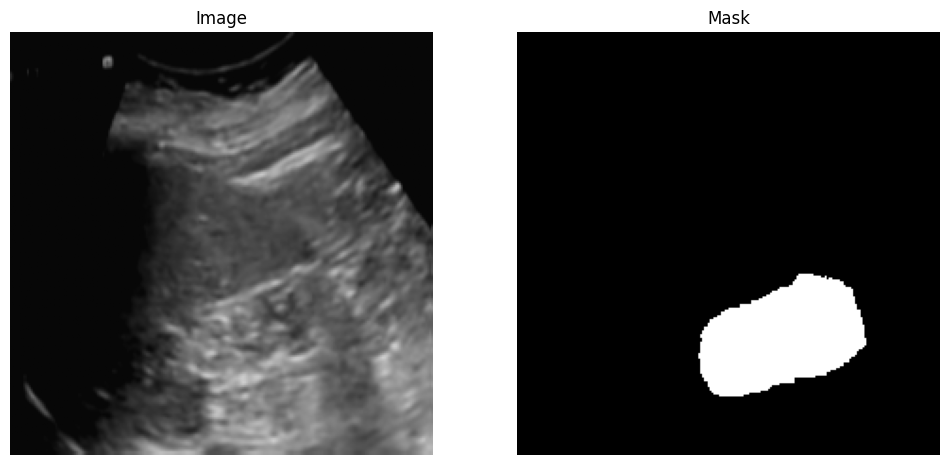

In [8]:
def plt_img(image, mask):
    # 將圖片從 [C, H, W] 轉換為 [H, W, C]
    image_np = image.permute(1, 2, 0).numpy()
    # 將掩碼轉換為 NumPy 陣列
    mask_np = mask.numpy()

    # 顯示圖片
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.show()
    
plt_img(img[0], mask[0])

In [9]:
def init_basic_elems():
    model_zoo = {'deeplabv3plus': DeepLabV3Plus, 'pspnet': PSPNet, 'deeplabv2': DeepLabV2}
    model = model_zoo['deeplabv3plus']('resnet18', 2 if dataset == 'kidney' else 19)

    head_lr_multiple = 10.0

    optimizer = SGD([{'params': model.backbone.parameters(), 'lr': 0.001},
                     {'params': [param for name, param in model.named_parameters()
                                 if 'backbone' not in name],
                      'lr': 0.001 * head_lr_multiple}],
                    lr=0.001, momentum=0.9, weight_decay=1e-4)

    model = DataParallel(model).cuda()

    return model, optimizer

In [10]:
model, optimizer = init_basic_elems()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
criterion = DiceLoss()

In [12]:
for img, mask in trainloader:
    img, mask = img.to(device), mask.to(device)
    pred = model(img)  
    break

In [13]:
print('img shape: ', img.shape)
print('mask shape: ', mask.shape)
print('pred shape: ', pred.shape)

img shape:  torch.Size([4, 3, 224, 224])
mask shape:  torch.Size([4, 224, 224])
pred shape:  torch.Size([4, 2, 224, 224])


In [14]:
loss = criterion(pred, mask)

print('Loss: ', loss.item())

Loss:  0.7777386903762817


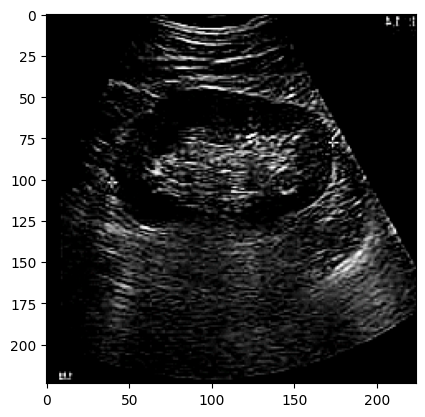

In [15]:
# 假設 img 是 PyTorch 張量，其形狀為 (3, 224, 224)
img = img[0].permute(1, 2, 0)  # 將形狀轉換為 (224, 224, 3)

# 將張量移動到 CPU 並轉換為 NumPy 陣列
img = img.cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())

plt.imshow(img)  # 在圖表中繪製圖片
plt.show()

In [16]:
# 檢查 masks 的最小值和最大值
print('mask min value: ', mask.min().item())
print('mask max value: ', mask.max().item())

print('pred min value: ', pred.min().item())
print('pred max value: ', pred.max().item())

mask min value:  0
mask max value:  1
pred min value:  -1.4581589698791504
pred max value:  1.6338595151901245


In [17]:
trainset = SemiDataset(dataset, data_root, 'semi_train', crop_size,
                       labeled_id_path, unlabeled_id_path, pseudo_mask_path, colormap=voc_mask_color_map)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                         pin_memory=True, num_workers=16, drop_last=True)

In [20]:
for i, (imgs, masks) in enumerate(trainloader):
    print(imgs.shape)
    print(masks.shape)
    break

torch.Size([4, 3, 224, 224])
torch.Size([4, 224, 224])


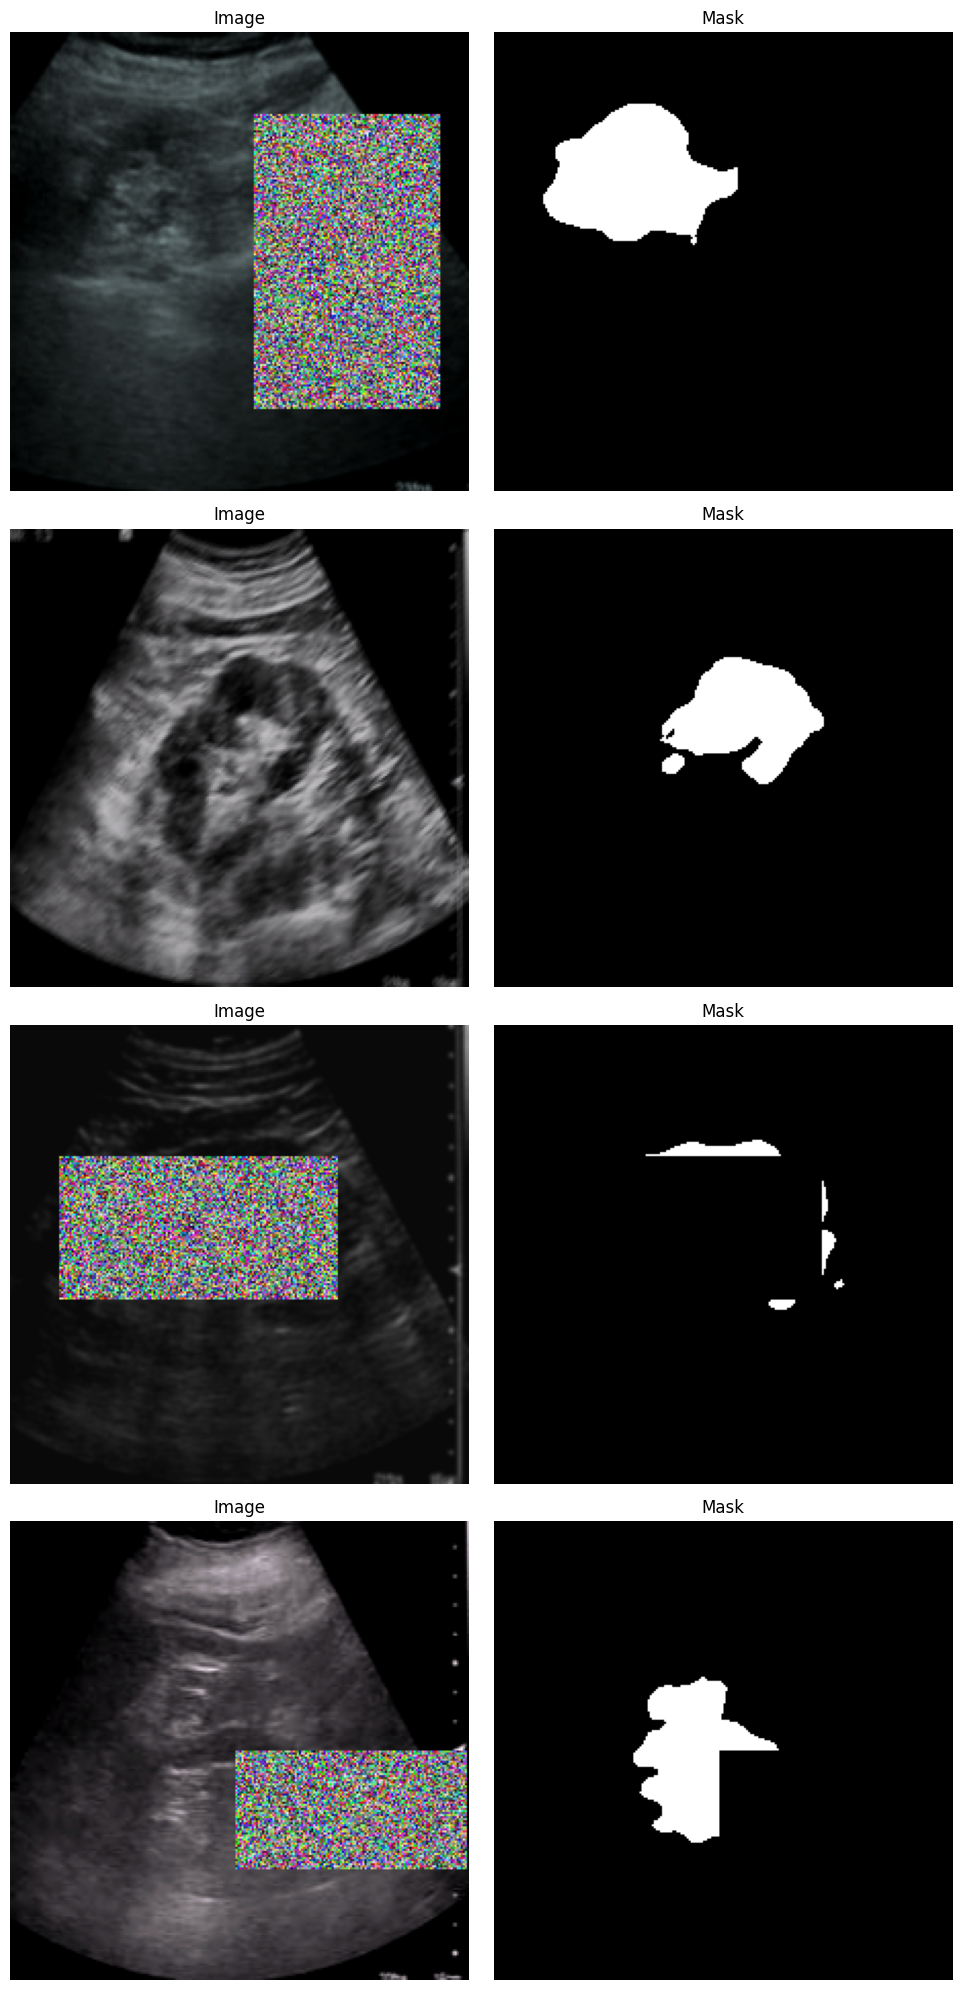

In [19]:
def plot_images_masks(trainloader):
    for i, (imgs, masks) in enumerate(trainloader):
        batch_size = imgs.size(0)
        fig, axes = plt.subplots(batch_size, 2, figsize=(10, batch_size * 5))
        for j in range(batch_size):
            # 將 img 從 tensor 轉為 numpy 陣列，並調整維度順序
            img_np = imgs[j].permute(1, 2, 0).cpu().numpy()
        
            # 將 mask 轉為 numpy 陣列
            mask_np = masks[j].cpu().numpy()
        
            # Plot image
            axes[j, 0].imshow(img_np)
            axes[j, 0].set_title('Image')
            axes[j, 0].axis('off')
        
            # Plot mask
            axes[j, 1].imshow(mask_np, cmap='gray')
            axes[j, 1].set_title('Mask')
            axes[j, 1].axis('off')

        plt.tight_layout()
        plt.show()
        
        break

# 假設 trainloader, device 和 model 已經定義
plot_images_masks(trainloader)